<a href="https://colab.research.google.com/github/scadusseau/RL-Algorithms-generalization-framework-/blob/master/FIFAproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing the dependencies

import pandas as pd

ranking = pd.read_csv('Classement Fifa.csv')
# Dataset is now stored in a Pandas Dataframe

print(len(ranking))

211


In [0]:
import numpy as np

class Leo5:
    """
    Description:
        A National soccer team is competing against other teams worldwide, in order to be the best team of the world.
        Each team's level is evaluated with a score (the values are obtained regarding the Fifa official ranking).
        Beating a team helps to improve the score. (The best team is the best because it can beat any openent)

    Source:
        This environment is the creation of S. CADUSSEAU, for an academic research project.

    Observation: # In this version, the score doesn't vary
        Type: Table[209][3]
        Num	Observation                 Min         Max
        x::	Team Name                    /           /    (first col.)
        :x:	Team Score                   0           n    (second col.)
        ::x Encounters                   0           n    (third col.)

        
    Actions:
        Type: Discrete(209)
        Num	Action
        1	Encounter Team 1
        :
        :
        :
        209 Encounter Team 209
        
    Reward:
        Reward varies according to the results (win or loss), the level of the opponent, the number of encounters against a same team, the total number of encounters.
        R = (w * vict_pts * L) - (l * def_pts * L) - Nb_enc * penalty - enc_tot * penalty_tot
        w: win variable (0 or 1)
        l: loss variable (0 or 1)
        vict_pts (= def_pts): 100 #arbitrarly fixed
        L: probability of losing #reflects the difficulty of an encounter, but this variable could be changed by another variable that represent the same aspect.
        Nb_enc: number of encounters against a same team
        enc_tot: total of number of encounters
        penalty: coefficient that deter encountering always the same team #value fixed arbitrarly
        penalty_tot: coefficient that deter encountering too many teams, and makes the agent achieve its goal as soon as possible #value fixed arbitrarly

    Starting State:
        The ranking table is initialized with 0 for the third column

    Episode Termination:
        The agent score is equal or under 0.
        The agent score is the best (let us arbitrarly fix the best score to 2000).
    """

    def __init__(self):
      self.vict_pts = 100
      self.def_pts = 100
      self.penalty = 2
      self.penalty_tot = 1

      self.action_space = np.array([i for i in range(1,210)])

      self.observation_space = np.array([ranking.Score,ranking.Rencontres])
      self.dictionnary = np.array([ranking.Nation])
      self.encounter_hist = []

      self.score = self.observation_space[0][210]

      #self.seed()


    #def seed(self, seed=None):
      #self.np_random, seed = seeding.np_random(seed)
      #return [seed]


    def encounter(self,action):
      # Calculate the win\loss probabilities
      W = 1/(1 + np.exp(0.01*(self.observation_space[0][action] - self.score)))
      """if self.score - self.observation_space[0][action] >= 200:
        W = 0.9
      if self.score - self.observation_space[0][action] <= -200:
        W = 0.1
      else:
        alpha = (0.9 - 0.5)/200
        W = (self.score - self.observation_space[0][action])*alpha + 0.5
      """
      L = 1 - W

      l = 0
      w = 1

      # Evaluating the end result
      res = np.random.rand()
      if res > W: #if res is higher than the probability of winning, then the encounter is lost
        l = 1
        w = 0

      self.observation_space[1][action] += 1
      self.encounter_hist.append([self.dictionnary[0][action],self.observation_space[0][action],w,score,L])

      return[L,l,w]


    def step(self,action):
      reward = 0
      result = self.encounter(action)
      L,l,w = result[0],result[1],result[2]
      Nb_enc = self.observation_space[1][action] - 1 #if we want the first encounter = 0
      enc_tot = sum(self.observation_space[1])

      print("Leo5 (" + str(self.score) + "pts) affronte " + self.dictionnary[0][action] + " (" + str(self.observation_space[0][action]) +"pts).") 
      reward = (w * self.vict_pts * 1) - (l * self.def_pts * L**2) - Nb_enc * self.penalty - enc_tot * self.penalty_tot
      #reward = (w * self.vict_pts * L) - (l * self.def_pts * L) - Nb_enc * self.penalty - enc_tot * self.penalty_tot
      self.score += reward

      #if(self.score < 1000):
       # self.score = 1000

      self.observation_space[0][210] = self.score

      end = False

      if ((enc_tot > 180) or (self.score > self.observation_space[0][0]) or (self.score < 600)):
        end = True

      if(w == 1):
        print("Leo5 gagne la rencontre et gagne " + str(reward) + "pts, obtenant le score total de " + str(self.score) + "pts.")
      else:
        print("Leo5 perd la rencontre et perd " + str(reward) + "pts, obtenant le score total de " + str(self.score) + "pts.")

      return self.observation_space, reward, end


    def _get_obs(self):
      return self.observation_space


    def reset(self):
      self.observation_space = np.array([ranking.Score,ranking.Rencontres])
      self.score = 1200
      self.encounter_hist = []
      return self._get_obs()






# Let's build the agent

In [0]:
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np

class ReplayBuffer(object):
  def __init__(self, max_size, input_shape, n_actions, discrete=False):
    self.mem_size = max_size
    self.mem_cntr = 0
    self.input_shape = input_shape
    self.discrete = discrete
    self.state_memory = np.zeros((self.mem_size, input_shape))
    self.new_state_memory = np.zeros((self.mem_size, input_shape))
    dtype = np.int8 if self.discrete else np.float32
    self.action_memory = np.zeros((self.mem_size, n_actions), dtype = dtype)
    self.reward_memory = np.zeros(self.mem_size)
    self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = state_
    self.reward_memory[index] = reward
    self.terminal_memory[index] = 1 - int(done)
    if self.discrete:
      actions = np.zeros(self.action_memory.shape[1])
      actions[action] = 1.0
      self.action_memory[index] = actions
    else:
      self.action_memory[index] = action
    self.mem_cntr += 1

  def sample_buffer(self, batch_size):
    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, batch_size)

    states = self.state_memory[batch]
    states_ = self.new_state_memory[batch]
    rewards = self.reward_memory[batch]
    actions = self.action_memory[batch]
    terminal = self.terminal_memory[batch]

    return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
  model = Sequential([Dense(fc1_dims, input_shape=(input_dims, )),
                      Activation('relu'),
                      Dense(fc2_dims),
                      Activation('relu'),
                      Dense(n_actions)])
  model.compile(optimizer=Adam(lr=lr), loss='mse',metrics=['acc'])

  return model

class Agent(object):
  def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
               input_dims, epsilon_dec=0.996, epsilon_end=0.01,
               mem_size=1000000, fname='dqn_model_database.h5'):
    self.action_space = [i for i in range(n_actions)]
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_dec = epsilon_dec
    self.epsilon_min = epsilon_end
    self.batch_size = batch_size
    self.model_file = fname

    self.memory = ReplayBuffer(mem_size, input_dims, n_actions, discrete=True)
    self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)
  
  def remember(self, state, action, reward, new_state, done):
    self.memory.store_transition(state, action, reward, new_state, done)

  def choose_action(self, state):
    state = state[np.newaxis, :]
    rand = np.random.random()
    if rand < self.epsilon:
      action = np.random.choice(self.action_space)
    else:
      actions = self.q_eval.predict(state)
      action = np.argmax(actions)

    return action

  def learn(self):
    if self.memory.mem_cntr < self.batch_size:
      return
    state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
    action_values = np.array(self.action_space, dtype=np.int8)
    action_indices = np.dot(action, action_values)

    q_eval = self.q_eval.predict(state)
    q_next = self.q_eval.predict(new_state)

    q_target = q_eval.copy()

    batch_index = np.arange(self.batch_size, dtype=np.int32)

    q_target[batch_index, action_indices] = reward + self.gamma*np.max(q_next, axis=1)*done

    self.q_eval.fit(state, q_target,epochs=10, verbose=0)
    

    self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min

  def save_model(self):
    path = "/content/gdrive/My Drive/"+self.model_file 
    self.q_eval.save(path)

  def load_model(self):
    path = "/content/gdrive/My Drive/"+self.model_file  
    self.q_eval = load_model(path)

Using TensorFlow backend.


# Let's train the agent

In [0]:
env = Leo5()

def preprocess(obs):
  return np.matrix.flatten(obs)

n_games = 100
agent = Agent(gamma=0.99, epsilon=0.8, alpha=0.0005, batch_size=1000, input_dims=211*2, n_actions = 210,
              epsilon_end=0.01)
  
scores = []
eps_history = []

for i in range(n_games):
  done = False
  score = 0
  observation = preprocess(env.reset())
  while not done:
    action = agent.choose_action(observation)
    observation_, reward, done = env.step(action)
    agent.remember(observation,action,reward,preprocess(observation_),done)
    score += reward
    observation = preprocess(observation_)
    if i%30 == 0:
      agent.learn()
      print(agent.epsilon)

  if(i >= n_games - 10):
    print("*********")
    print("episode " + str(i))
    print("*********")
    for enc in env.encounter_hist:
      print(enc)
     

  eps_history.append(agent.epsilon)
  scores.append(score)

  avg_score = np.mean(scores[max(0, i-100):(i+1)])
  print("\n============\n")
  print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score)
  print("\n============\n")




Leo5 (1200pts) affronte Afrique du Sud (1334pts).
Leo5 perd la rencontre et perd -63.80403072841523pts, obtenant le score total de 1136.1959692715848pts.
0.8
Leo5 (1136.1959692715848pts) affronte Autriche (1507pts).
Leo5 perd la rencontre et perd -97.26961773108837pts, obtenant le score total de 1038.9263515404964pts.
0.8
Leo5 (1038.9263515404964pts) affronte Israel (1260pts).
Leo5 perd la rencontre et perd -84.21785919157509pts, obtenant le score total de 954.7084923489213pts.
0.8
Leo5 (954.7084923489213pts) affronte Rep-Dom (1019pts).
Leo5 perd la rencontre et perd -46.95650470889933pts, obtenant le score total de 907.751987640022pts.
0.8
Leo5 (907.751987640022pts) affronte Bulgarie (1381pts).
Leo5 perd la rencontre et perd -103.26206480491392pts, obtenant le score total de 804.489922835108pts.
0.8
Leo5 (804.489922835108pts) affronte Nigeria (1493pts).
Leo5 perd la rencontre et perd -105.79573086385544pts, obtenant le score total de 698.6941919712526pts.
0.8
Leo5 (698.6941919712526pt

# Some statistics

5
1000
0.5665268529219021
10
[-608.0796313452786, -626.3273613729694, 590.8561526866249, -601.0179508877086, 642.3461509544709, -604.4576794454617, -623.1545590188908, -606.8192573214004, -700.4766400137252, -695.8701084707593, 649.1342317605091, 567.4287259875659, 579.0, -623.6901753576362, 592.9817466475829, 571.4436123378057, 573.8811140820866, -608.8484895493235, -674.8067934455873, -631.7731816737381, -671.9106985408487, 608.2305227016808, 567.4133345511618, 579.0, -668.1002714367987, 577.0, -686.2145741781944, 636.4080142492286, -701.6906132775448, 569.7705647581788, 579.0, -674.786689415712, -694.8271161734212, -620.9095421321357, -690.9373061087239, -651.2279740144033, 632.3957581851801, -619.2528524180792, 643.3092170733483, 579.0, -694.0028522933778, 606.530744595393, 635.8987313107414, -623.3452733691302, -617.971977879833, -701.1786165611044, 571.8811140820866, 584.4945243945194, 579.0, 611.7094854953643, -640.3947556372224, -680.1327976404089, 644.903608265204, 595.0225801

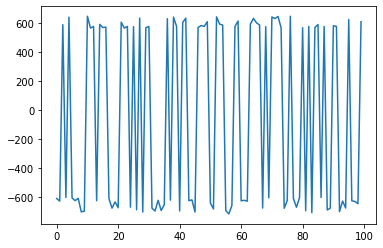

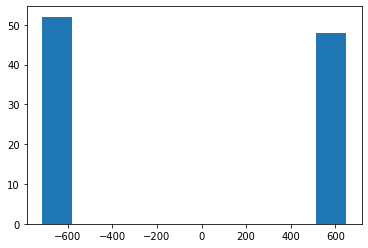

In [0]:
import numpy as np

a = np.array([i for i in range(1,10)])
print(a[4])
#b = ranking.Rencontres
b = np.array([ranking.Score,ranking.Rencontres])
#b = np.array([[i for i in range(1,10)],[j for j in range(40,50)],[l for l in range(50,60)]])
print(b[0][210])

np.exp(1)

res = np.random.rand()
print(res)

c = sum(a)
c
d = np.array([[i for i in range(1,10)],[i for i in range(1,5)],[i for i in range(1,10)]])
e = sum(d[1])
print(e)
print(scores)
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()
plt.hist(scores)
plt.show()

In [0]:
1/(1+np.exp(0.15))

0.46257015465625045

In [0]:
a = 0
for i in range(len(scores)):
  if scores[i]<0:
    a+=1

print(a)
print(1-a/100)

52
0.48
